# Imports

In [1]:
import torch
import numpy as np
import os
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

# Globals

In [2]:
# GLOBALS FOR THE TEXT OF THE CAR PLATE

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# FULL DATASETS

train_path="/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/train"
eval_path_medium="/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/eval"
test_path_medium="/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/test"

train_folder=os.listdir(train_path) 
eval_folder=os.listdir(eval_path_medium)
test_folder=os.listdir(test_path_medium)

# MEDIUM DATASETS

train_path_medium="/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/train_medium"
eval_path_medium="/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/eval_medium"
test_path_medium="/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/test_medium"

# Utils

In [3]:
# BOUNDING BOX FUNCTION 

def get_bounding_box(file):
    numbers=file.split("-")
    values=numbers[3]
    values_v2=values.split("&")
    values_v3=[]
    for i in range(len(values_v2)):
        if "_" in values_v2[i]:
            values_v3.append(values_v2[i].split("_"))
    t=[values_v2[0],values_v3[0],values_v3[1],values_v3[2],values_v2[-1]]
    final_values = [int(x) for item in t for x in (item if isinstance(item, list) else [item])]
    x_coords=[final_values[0],final_values[2],final_values[4],final_values[6]]
    y_coords=[final_values[1],final_values[3],final_values[5],final_values[7]]
    x_min = min(x_coords)
    y_min = min(y_coords)
    x_max = max(x_coords)
    y_max = max(y_coords)
    
    return [float(x_min), float(y_min), float(x_max), float(y_max)]

# INTERSECTION OVER UNION FUNCTION

def compute_IoU(box1, box2):

    box1=box1.squeeze()
    box2=box2.squeeze()
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    area_of_intersection = max(0, xB - xA) * max(0, yB - yA)
    area_box1 = (box1[2] - box1[0]) * (box1[3]- box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    IoU = area_of_intersection / float(area_box1 + area_box2 - area_of_intersection)

    return IoU

# CAR PLATE TEXT FUNCTION

def get_text(file):
    values=file.split("-")
    text=str(values[4])
    indices=text.split("_")
    province_character=provinces[int(indices[0])]
    alphabet_character=alphabet[int(indices[1])]
    ads_charachters=[ads[int(i)] for i in indices[2:]]
    plate_text=province_character+alphabet_character+"".join(ads_charachters)
    
    return plate_text

# Dataset

In [ ]:
# CHECKING DATASET STRUCTURE

print(f"Nmumber of training samples: {len(train_folder)}")
print(f"Nmumber of evaluation samples: {len(eval_folder)}")
print(f"Nmumber of testing samples: {len(test_folder)}")
print(f"Total number of samples: {len(train_folder)+len(test_folder)+len(eval_folder)}")

# CHECKING ERRORS FOR FUNCTION: "get_bounding_box"

for file in train_folder: # executed also for eval and test set with no Error raised
    numbers=file.split("-")
    values=numbers[3]

    # if len(values) != 31:                                                                   questo controllo non serve in quanto dipende da quante cifre ogni numero ha
    #     raise ValueError(f" 1 st exception: Invalid plate text format in filename: {file}")
    
    values_v2=values.split("&")

    if len(values_v2) != 5:
        raise ValueError(f"2 nd exception: Invalid plate text format in filename: {file}")
    
    values_v3=[]
    for i in range(len(values_v2)):
        if "_" in values_v2[i]:
            values_v3.append(values_v2[i].split("_"))

    if len(values_v3) != 3:
        raise ValueError(f"3 rd exception: Invalid plate text format in filename: {file}")
    
    t=[values_v2[0],values_v3[0],values_v3[1],values_v3[2],values_v2[-1]]
    final_values = [int(x) for item in t for x in (item if isinstance(item, list) else [item])]
    x_coords=[final_values[0],final_values[2],final_values[4],final_values[6]]
    y_coords=[final_values[1],final_values[3],final_values[5],final_values[7]]

    if len(x_coords) != 4:
        raise ValueError(f"4 th exception: Invalid plate text format in filename: {file}")

 # CHECKING ERRORS FOR FUNCTION: "get_text"
 
for file in train_folder: # executed also for eval and test set with no Error raised
        values=file.split("-")

        if len(values)!=7:
            raise ValueError(f"1 st exception occurred: Invalid plate text format in filename: {file}")
        
        text=str(values[4])

        # if len(text)!=7:                                                                                questo controllo non serve in quanto dipende da quante cifre ogni numero ha cifre diverse
        #     raise ValueError(f"2 nd exception occurred: Invalid plate text format in filename: {file}") 
        
        indices=text.split("_")

        if len(indices) != 8:
            raise ValueError(f"3 rd exception occurred: Invalid plate text format in filename: {file}")
        
        province_character=provinces[int(indices[0])]
        alphabet_character=alphabet[int(indices[1])]
        ads_charachters=[ads[int(i)] for i in indices[2:]]
        plate_text=province_character+alphabet_character+"".join(ads_charachters)

        if len(plate_text) != 8:
            raise ValueError(f"4 th exception occurred: Invalid plate text format in filename: {file}")

# ESEMPIO DI PROVA CON DUE FILE PER FUNZIONE: "get_bounding_box"

file="308069444444444444-91_94-8&424_589&564-578&564_27&553_8&431_589&424-0_0_3_24_32_25_32_25-100-241.jpg" # FILE CHE NON DA PROBLEMI CON LA LUNGHEZZA DI VALUES
numbers=file.split("-")
values=numbers[3]
values_v2=values.split("&")
values_v3=[]
for i in range(len(values_v2)):
    if "_" in values_v2[i]:
        values_v3.append(values_v2[i].split("_"))
t=[values_v2[0],values_v3[0],values_v3[1],values_v3[2],values_v2[-1]]
final_values = [int(x) for item in t for x in (item if isinstance(item, list) else [item])]
x_coords=[final_values[0],final_values[2],final_values[4],final_values[6]]
y_coords=[final_values[1],final_values[3],final_values[5],final_values[7]]
x_min = min(x_coords)
y_min = min(y_coords)
x_max = max(x_coords)
y_max = max(y_coords)

file2="0115711805556-88_269-312&388_484&456-484&445_314&456_312&396_481&388-0_0_3_24_28_28_28_28-154-41.jpg" # FILE CHE DA PROBLEMI CON LA LUNGHEZZA DI VALUES
numbers=file.split("-")
values=numbers[3]
values_v2=values.split("&")
values_v3=[]
for i in range(len(values_v2)):
    if "_" in values_v2[i]:
        values_v3.append(values_v2[i].split("_"))
t=[values_v2[0],values_v3[0],values_v3[1],values_v3[2],values_v2[-1]]
final_values = [int(x) for item in t for x in (item if isinstance(item, list) else [item])]
x_coords=[final_values[0],final_values[2],final_values[4],final_values[6]]
y_coords=[final_values[1],final_values[3],final_values[5],final_values[7]]
x_min = min(x_coords)
y_min = min(y_coords)
x_max = max(x_coords)
y_max = max(y_coords)

# ESEMPIO DI PROVA CON DUE FILE PER FUNZIONE: get_text

file="30237890625-87_88-197&472_449&567-449&553_201&567_197&472_448&477-10_2_3_24_31_33_26_24-192-75.jpg" # FILE CHE NON DA PROBLEMI CON LA LUNGHEZZA DI TEXT
values=file.split("-")
text=str(values[4])
indices=text.split("_")
if len(indices) != 8:
    raise ValueError(f"Invalid plate text format in filename: {file}")
province_character=provinces[int(indices[0])]
alphabet_character=alphabet[int(indices[1])]
ads_charachters=[ads[int(i)] for i in indices[2:]]
plate_text=province_character+alphabet_character+"".join(ads_charachters)
print(values,text,len(text),indices,plate_text)

file2="0115711805556-88_269-312&388_484&456-484&445_314&456_312&396_481&388-0_0_3_24_28_28_28_28-154-41.jpg" # FILE CHE DA PROBLEMI CON LA LUNGHEZZA DI TEXT
values=file2.split("-")
text=str(values[4])
indices=text.split("_")
if len(indices) != 8:
    raise ValueError(f"Invalid plate text format in filename: {file}")
province_character=provinces[int(indices[0])]
alphabet_character=alphabet[int(indices[1])]
ads_charachters=[ads[int(i)] for i in indices[2:]]
plate_text=province_character+alphabet_character+"".join(ads_charachters)
print(values,text,len(text),indices,plate_text)

In [4]:
# DATASET  CLASS  

class CCPD_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        self.folder = os.listdir(path)
        self.images = [f for f in self.folder if f.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        file = self.images[idx]
        full_path = os.path.join(self.path, file)
        image = Image.open(full_path).convert("RGB")

        bbox = get_bounding_box(file)
        tensor_bbox = torch.tensor([bbox], dtype=torch.float32)
        label = torch.tensor([1], dtype=torch.int64)  

        target = {"boxes": tensor_bbox, "labels": label}

        if target["boxes"].shape[0] != target["labels"].shape[0]:
            raise ValueError(f"Mismatch in number of boxes and labels for file: {file}")

        if self.transforms:
            image = self.transforms(image)

        return image, target
    
# COLLATE FUNCTION
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
# CHOICE OF THE DATASET

transform = T.ToTensor()
train_dataset_medium = CCPD_Dataset(train_path_medium, transforms=transform)
eval_dataset_medium = CCPD_Dataset(eval_path_medium, transforms=transform)
test_dataset_medium = CCPD_Dataset(test_path_medium, transforms=transform)

train_dataloader_medium = DataLoader(train_dataset_medium, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=0) 
eval_dataloader_medium = DataLoader(eval_dataset_medium, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0)  
test_dataloader_medium = DataLoader(test_dataset_medium, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0)  

# Network

In [6]:
# MODEL

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)
model.rpn.post_nms_top_n_train = 500
model.rpn.post_nms_top_n_test = 500
model.roi_heads.detections_per_img = 50  
device="cpu"
model.to(device)

/home/filippo/miniconda3/envs/virtualenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/filippo/miniconda3/envs/virtualenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Train

In [ ]:
# TRAINING LOOP

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
best_boxes=[]
best_avg_iou = 0.0
num_epochs=1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    count=1
    for images, targets in train_dataloader_medium:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        train_loss += losses.item()
        print(f"Batch: {count} Training Loss: {losses.item():.4f}")
        count+=1

    model.eval()
    total_iou = 0
    count = 0
    with torch.no_grad():
        for images, targets in eval_dataloader_medium:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for pred, target in zip(outputs, targets):
                pred_boxes = pred['boxes'].to(device)
                gt_boxes = target['boxes'].to(device)

                if len(pred_boxes) > 0:
                    best_iou = 0.0
                    best_box = None
                    for box, score in zip(pred['boxes'], pred['scores']):
                        if score > 0.0:
                            iou = compute_IoU(box, gt_boxes[0])
                            if iou > best_iou:
                                best_iou = iou
                                best_box = box
                    if best_iou > 0:
                        total_iou += best_iou
                        count += 1
                        best_boxes.append(best_box.cpu())

    avg_iou = total_iou / count if count > 0 else 0

    if avg_iou > best_avg_iou:
        best_avg_iou = avg_iou
        torch.save(model.state_dict(), "best_frcnn_model.pth")
        print(f"Saved best model with IoU: {best_avg_iou:.4f}")

    print(f"Average IoU on eval set: {avg_iou:.4f}")

In [7]:
# FUNCTION TO LOAD THE MODEL

def load_Fasterrcnn(device):
    model = fasterrcnn_resnet50_fpn(num_classes=2)  
    model.load_state_dict(torch.load('model_weights/best_frcnn_model_final_version.pth', map_location="cpu"))
    model.to(device)
    model.eval()
    return model

model=load_Fasterrcnn("cpu")
device="cpu"

/tmp/ipykernel_7573/3135391269.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights/best_frcnn_model_final_version.pth', map_l

# Evaluation

In [8]:
# CROP FUNCTIONS WITH PREDICTED BOUNDING BOX

def crop_image_with_RCNN(file):
    image = Image.open(file).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device) 
    with torch.no_grad():
        prediction = model(img_tensor)[0]
        if len(prediction['boxes']) == 0:
            print(f"No box found for image: {file}")
            return None
        best_bb = prediction['boxes'][0].to(device).int()
        cropped = img_tensor[0, :, best_bb[1]:best_bb[3], best_bb[0]:best_bb[2]]
        cropped_resized = F.interpolate(cropped.unsqueeze(0), size=(48, 144), mode='bilinear', align_corners=False)
        return cropped_resized.squeeze(0)  

def crop_folder_with_RCNN(folder_path):
    cropped_folder = []
    files = os.listdir(folder_path)
    for file in files:
        full_path = os.path.join(folder_path, file)
        gt_text=get_text(full_path)
        cropped_image = crop_image_with_RCNN(full_path)
        if cropped_image is not None:
            cropped_folder.append([cropped_image, gt_text])
    return cropped_folder

# CROP FUNCTIONS WITH GROUND TRUTH BOUNDING BOX

def crop_image_with_ground_truth(full_path):
    filename = os.path.basename(full_path)  
    bb = get_bounding_box(filename)
    image = Image.open(full_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image)
    cropped = img_tensor[:, int(bb[1]):int(bb[3]), int(bb[0]):int(bb[2])]
    cropped_resized = F.interpolate(cropped.unsqueeze(0), size=(48, 144), mode='bilinear', align_corners=False)
    return cropped_resized.squeeze(0)

def crop_folder_with_ground_truth(folder_path):
    cropped_folder = []
    files = os.listdir(folder_path)
    for file in files:
        full_path = os.path.join(folder_path, file)
        gt_text = get_text(file)  # Get ground truth text
        cropped_image = crop_image_with_ground_truth(full_path)
        cropped_folder.append([cropped_image, gt_text])  # Store image and text pair
    return cropped_folder

In [ ]:
# TESTING THE UNTRAINED MODEL USING THE BEST BOUNDING BOX (OUTPUTS THE IMAGE WITH THE PREDICTED BOUNDING BOX)

model = fasterrcnn_resnet50_fpn(num_classes=2)  
device="cpu"
model.to(device)
model.eval()
folder=os.listdir(test_path_medium)
for image in folder:
    if image.endswith(".jpg"):
        image_path = os.path.join(test_path_medium, image)
        image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        pred = output[0]
        score = output[0]['scores'][0].item()        
        best_bb=pred['boxes'][0].cpu()
        gt_box=get_bounding_box(image_path)
        tensor_bbox = torch.tensor([gt_box], dtype=torch.float32)
        iou=compute_IoU(best_bb, tensor_bbox)
        plt.imshow(image)
        ax = plt.gca()
        x1, y1, x2, y2 = best_bb
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f" score: {score:.2f}, IoU: {iou:.2f}", color='white', bbox=dict(facecolor='red', alpha=0.5))
        plt.axis('off')
        plt.show()

In [ ]:
# TESTING THE TRAINED MODEL USING THE BEST BOUNDING BOX (OUTPUTS THE IMAGE WITH THE PREDICTED BOUNDING BOX)

model=load_Fasterrcnn("cpu")
folder=os.listdir(test_path_medium)
for image in folder:
    if image.endswith(".jpg"):
        image_path = os.path.join(test_path_medium, image)
        image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        pred = output[0]
        score = output[0]['scores'][0].item()        
        best_bb=pred['boxes'][0].cpu()
        gt_box=get_bounding_box(image_path)
        tensor_bbox = torch.tensor([gt_box], dtype=torch.float32)
        iou=compute_IoU(best_bb, tensor_bbox)
        plt.imshow(image)
        ax = plt.gca()
        x1, y1, x2, y2 = best_bb
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f" score: {score:.2f}, IoU: {iou:.2f}", color='white', bbox=dict(facecolor='red', alpha=0.5))
        plt.axis('off')
        plt.show()

In [ ]:
# COMPUTING AVERAGE INTESECTION OVER UNION ON TEST SET USING THE TRAINED MODEL

model=load_Fasterrcnn("cpu")
folder=os.listdir("/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/test_medium")
total_iou=0
for image in folder:
    if image.endswith(".jpg"):
        image_path = os.path.join("/home/filippo/Documents/Visual Studio Code/Computer_Vision/Data/test_medium", image)
        image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        pred = output[0]
        if len(output[0]['scores'])>0:
            score = output[0]['scores'][0].item()        
            best_bb=pred['boxes'][0].to(device)
            gt_box=get_bounding_box(image_path)
            tensor_bbox = torch.tensor([gt_box], dtype=torch.float32)
            iou=compute_IoU(best_bb, tensor_bbox)
            total_iou+=iou
print(f"Average IoU: {total_iou/len(folder)}") # 0.87

In [ ]:
# SHOWING THE RESULTS OF THE TRAINED MODEL USING "crop_image_with_RCNN" (OUTPUTS THE CROPPED IMAGE AROUND THE PREDICTED BOUNDING BOX)

for image in os.listdir(test_path_medium):
    if image.endswith(".jpg"):
        image_path = os.path.join(test_path_medium, image)
        cropped = crop_image_with_RCNN(image_path)
        plt.imshow(cropped.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.title("Cropped Image")
        plt.show()

In [ ]:
# SHOWING THE RESULTS OF THE TRAINED MODEL USING "crop_folder_with_RCNN" (OUTPUTS THE CROPPED IMAGE AROUND THE PREDICTED BOUNDING BOX FOR A WHOLE SET OF IMAGES)

model=load_Fasterrcnn("cpu")
cropped_folder=crop_folder_with_RCNN(test_path_medium)
image=cropped_folder[0][0]
image_np = image.permute(1, 2, 0).cpu().numpy()
plt.imshow(image_np)
plt.axis('off')
plt.show()
print(f"ground truth text: {cropped_folder[0][1]}")

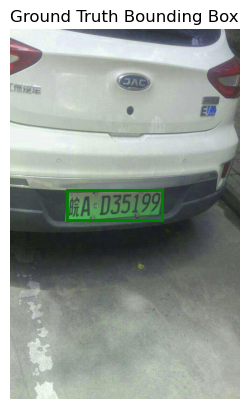

Predicted bounding box: [174.0663604736328, 506.4112243652344, 480.7063293457031, 599.9340209960938]


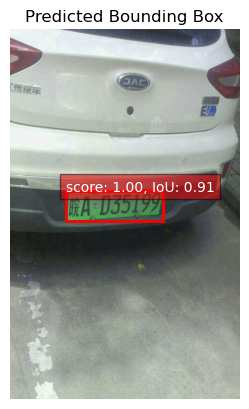

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

file = "/home/filippo/Documents/Visual Studio Code/Computer_Vision/Prove/single_sample_test/03125-89_263-177&502_477&597-464&581_177&597_185&513_477&502-0_0_3_27_29_25_33_33-102-60.jpg"

# Load image and GT box
gt_bb = get_bounding_box(file)
image = Image.open(file).convert("RGB")

# Show ground truth bounding box
plt.imshow(image)
ax = plt.gca()
x1, y1, x2, y2 = gt_bb
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='green', linewidth=2, label='GT')
ax.add_patch(rect)
plt.axis('off')
plt.title("Ground Truth Bounding Box")
plt.show()

# Model prediction
with torch.no_grad():
    image_tensor = transform(image).unsqueeze(0).to(device)
    output = model(image_tensor)
    pred = output[0]
    score = pred['scores'][0].item()        
    best_bb = pred['boxes'][0].cpu()
    
    # Print predicted bounding box
    print(f"Predicted bounding box: {best_bb.tolist()}")  # <<< OUTPUT HERE
    
    # Compute IoU with GT
    gt_box = get_bounding_box(file)
    tensor_bbox = torch.tensor([gt_box], dtype=torch.float32)
    iou = compute_IoU(best_bb, tensor_bbox)
    
    # Plot prediction
    fig, ax = plt.subplots()
    ax.imshow(image)
    x1, y1, x2, y2 = best_bb
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2, label='Prediction')
    ax.add_patch(rect)
    ax.text(x1, y1, f"score: {score:.2f}, IoU: {iou:.2f}", color='white',
            bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.title("Predicted Bounding Box")
    plt.show()
